In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import map_coordinates

In [2]:
rgbFile = 'dem_data/rgb_image/true_color.tiff'
demFile = "dem_data/output_hh.tif"

rgbFile = './data_ignore/1m_res/1m_latlon.tif'
demFile = './data_ignore/output_hh.tif'

ID='250704_1233'

* Import images

In [3]:
# --- 2. Open your actual GeoTIFFs ---
try:
    with rasterio.open(rgbFile) as src_high: # Replace with your high-res file
        if src_high.count>1 :
            high_res_imageR = src_high.read(1)
            high_res_imageG = src_high.read(2)
            high_res_imageB = src_high.read(3)
        else:
            high_res_imageR=high_res_imageG=high_res_imageB = src_high.read(1)
        rgb = np.stack([high_res_imageR,high_res_imageG,high_res_imageB])
        high_res_profile = src_high.profile
        high_res_transform = src_high.transform
        high_res_crs = src_high.crs
        print('High:',src_high.bounds)
        print('High:',src_high.res)

    with rasterio.open(demFile) as src_low: # Replace with your low-res file
        low_res_image = src_low.read(1)
        low_res_profile = src_low.profile
        low_res_transform = src_low.transform
        low_res_crs = src_low.crs
        print('Low:',src_low.bounds)
        print('Low:',src_low.res)

except rasterio.errors.RasterioIOError as e:
    print(f"Error opening GeoTIFF files: {e}")
    print("Please ensure 'high_res_dummy.tif' and 'low_res_dummy.tif' exist or update the file paths.")
    exit()



High: BoundingBox(left=23.750880400868688, bottom=37.65239209143433, right=23.865578624978372, top=37.924990168649806)
High: (9.549431696751722e-06, 9.549431696751722e-06)
Low: BoundingBox(left=23.770972211111115, bottom=37.78902778888888, right=23.880972211111114, top=37.857361122222215)
Low: (0.0002777777777777778, 0.0002777777777777778)


* Perform allignment and cropping

In [4]:
# --- 3. Define Cropping Area (High-Res) ---
# Let's define a crop by pixel indices for simplicity in this example.
# I use the upper-left and the bottom-right corners of the image intersection.

crop_row_start_high,crop_col_start_high = rasterio.transform.rowcol(high_res_transform,23.7712, 37.8571)
crop_row_end_high  ,crop_col_end_high   = rasterio.transform.rowcol(high_res_transform,23.8655, 37.7894)

# Keep the cropped versino of the RGB image
cropped_rgb = rgb[:,crop_row_start_high:
                        crop_row_end_high,
                        crop_col_start_high:
                        crop_col_end_high]


# Calculate the dimensions of the cropped area
cropped_height_high = crop_row_end_high - crop_row_start_high
cropped_width_high = crop_col_end_high - crop_col_start_high

print(f"\nCropping high-res image from pixel ({crop_row_start_high},{crop_col_start_high}) to ({crop_row_end_high},{crop_col_end_high})")
print(f"Cropped high-res dimensions: {cropped_height_high} rows x {cropped_width_high} cols")

# --- 4. Get High-Res Cropped Pixel Locations (Geographic Coordinates) ---
# Create arrays for row and column indices within the cropped high-res area
cropped_rows_high, cropped_cols_high = np.indices((cropped_height_high, cropped_width_high))

# Adjust indices to be absolute within the original high-res image
abs_rows_high = cropped_rows_high + crop_row_start_high
abs_cols_high = cropped_cols_high + crop_col_start_high

# Convert absolute high-res pixel indices to geographic coordinates (centroids)
# (x, y) = (longitude, latitude)
xs_high, ys_high = rasterio.transform.xy(high_res_transform, abs_rows_high, abs_cols_high)

# These xs_high and ys_high are 2D arrays, representing the geographic X and Y for each
# pixel in the high-resolution cropped area.


# --- 5. Transform High-Res Coordinates to Low-Res Pixel Space ---
# We need the inverse of the low-resolution transform to convert geographic coords
# back to pixel coords in the low-res image.
# It is importatnt at this point that the resulting pixel liocations are axpressed as floats so that the 
# interpolation can be effective 
#rows_low, cols_low = rasterio.transform.rowcol(low_res_transform, xs_high, ys_high) # retunrs integers only
cols_low,rows_low = ~low_res_transform * np.vstack([xs_high, ys_high]) # workaround to take floats


# --- 6. Perform Bicubic Interpolation ---
# scipy.ndimage.map_coordinates expects coordinates in (row_indices, col_indices) format.
# It also expects them as a single array of (N, 2) or (2, N)
# 'order=3' specifies bicubic interpolation.
# 'mode='nearest'' handles values outside the low-res image extent by using the nearest pixel value.
# You might want 'mode='constant'' with a fill_value (e.g., NaN) if out-of-bounds should be flagged.
interpolated_values = map_coordinates(
    input=low_res_image,
    coordinates=[rows_low, cols_low], # Note the order: [row_indices, col_indices]
    order=4, # Bicubic interpolation
    mode='nearest' # How to handle points outside the input array boundaries
)

interpolated_values = interpolated_values.reshape((cropped_height_high,cropped_width_high))


Cropping high-res image from pixel (7109,2127) to (14198,12002)
Cropped high-res dimensions: 7089 rows x 9875 cols


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


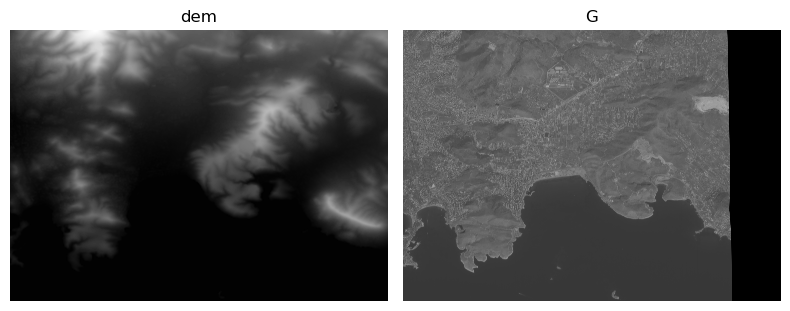

In [5]:
# %matplotlib qt

# Create a 2x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# Display images
axes[0].imshow(interpolated_values, cmap='gray')
axes[0].set_title('dem'); axes[0].axis('off')

axes[1].imshow(cropped_rgb.transpose((1,2,0))/rgb.max())
axes[1].set_title('G'); axes[1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

* Create new DEM file

In [7]:
# --- 7. Create New Output Image and Adjust Profile ---
# The interpolated_values array has the same shape as your high-resolution cropped area.
# Now, prepare to save it as a new GeoTIFF.

# Calculate the new transform for the cropped output GeoTIFF.
# It will have the same resolution as high_res_image, but its origin will be
# the top-left corner of the cropped area.
origin_long, origin_lat = rasterio.transform.xy(high_res_transform, crop_row_start_high, crop_col_start_high)

# The new transform for the output GeoTIFF
new_transform = rasterio.transform.from_origin(
    origin_long,
    origin_lat,
    high_res_transform.a, # Resolution X (from high-res)
    high_res_transform.e  # Resolution Y (from high-res)
)

# Update the profile for the output GeoTIFF
output_profile = high_res_profile.copy()
output_profile.update({
    'height': cropped_height_high,
    'width': cropped_width_high,
    'transform': new_transform,
    'crs': high_res_crs, # Ensure CRS is consistent
    'dtype': "float32" # Use the dtype of interpolated data
})

# --- 8. Save as GeoTIFF ---
output_filename = f'data_ignore/{ID}_DEM_1m.tif'
with rasterio.open(output_filename, 'w', **output_profile) as dst:
    dst.write(interpolated_values.reshape((cropped_height_high,cropped_width_high)), 1)

print(f"\nSuccessfully resampled low-resolution data to high-resolution crop extent.")
print(f"Output saved to: {output_filename}")
print(f"Output dimensions: {interpolated_values.shape}")
print(f"Output transform: {new_transform}")
print(f"Output CRS: {output_profile['crs']}")


Successfully resampled low-resolution data to high-resolution crop extent.
Output saved to: data_ignore/250704_1233_DEM_1m.tif
Output dimensions: (7089, 9875)
Output transform: | 0.00, 0.00, 23.77|
| 0.00, 0.00, 37.86|
| 0.00, 0.00, 1.00|
Output CRS: EPSG:4326


* Create new RGB/GRAY

In [11]:
# --- 7. Create New Output Image and Adjust Profile ---

# Update the profile for the output GeoTIFF
output_profile = high_res_profile.copy()
output_profile.update({
    'height': cropped_height_high,
    'width': cropped_width_high,
    'transform': new_transform,
    'crs': high_res_crs, # Ensure CRS is consistent
    'dtype': cropped_rgb.dtype, # Use the dtype of interpolated data
    'count': 3
})

# --- 8. Save as GeoTIFF ---
output_filename = f'data_ignore/{ID}_RGB_1m.tif'
with rasterio.open(output_filename, 'w', **output_profile) as dst:
    dst.write(cropped_rgb[0], 1)
    dst.write(cropped_rgb[1], 2)
    dst.write(cropped_rgb[2], 3)

print(f"\nSuccessfully resampled high-resolution crop .")
print(f"Output saved to: {output_filename}")
print(f"Output dimensions: {interpolated_values.shape}")
print(f"Output transform: {new_transform}")
print(f"Output CRS: {output_profile['crs']}")


Successfully resampled high-resolution crop .
Output saved to: data_ignore/250704_1233_RGB_1m.tif
Output dimensions: (7089, 9875)
Output transform: | 0.00, 0.00, 23.77|
| 0.00, 0.00, 37.86|
| 0.00, 0.00, 1.00|
Output CRS: EPSG:4326
